# Stat-Win Correlation analysis: Main

> by Imt of NYXL (imt@andbox.com)

# Data Preparation

In [1]:
import os
import pandas as pd 
from tqdm import tqdm
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_ind_from_stats

## 0. Preprocess simple PHS files

> define `is_all_time` == True or False

> if `is_all_time` == False, then specify `phs_name = phs_list[#]`

> add `is_match_winner` and `is_map_winner` features into the dataframe

In [2]:
# File path of prepared new_phs
path = "./data/"
phs_list = os.listdir(path)
phs_list = [file_name for file_name in phs_list if file_name.endswith(".csv")]

# choose all time or specific season
is_all_time = False # set True if target data is all seasons data

if is_all_time == True:
    li = []
    for phs_name in phs_list:
        new_phs = pd.read_csv(f'{path}{phs_name}')
        li.append(new_phs)
    new_phs = pd.concat(li, axis=0, ignore_index=True)
    all_seasons = True

else:
    phs_name = phs_list[7] # set index of target csv file
    print(f'selected phs: {phs_name}')
    new_phs = pd.read_csv(f'{path}{phs_name}')
    all_seasons = False

# Add 'is_match_winner' feature
def match_winner(df):
    '''
    args, get a dataframe, expected to be phs with selected features
    targets, winner = 1; loser = 0
    '''
    if df['match_winner'] == df['team_name']: #there's 'team' column in 2018 data 
        return 1
    elif df['match_winner'] == 'draw':
        return -1
    else:
        return 0

new_phs['is_match_winner'] = new_phs.apply(match_winner, axis = 1)

# Add 'is_map_winner' feature
def map_winner(df):
    '''
    args, get a dataframe, expected to be phs with selected features
    targets, winner = 1; loser = 0; draw = -1
    '''
    if df['map_winner'] == df['team_name']:
        return 1
    elif df['map_winner'] == 'draw':
        return -1
    else:
        return 0

new_phs['is_map_winner'] = new_phs.apply(map_winner, axis = 1)

selected phs: new_phs_2019_stage_2.csv


## 1. Feature Engineering

> define a `target_hero` = <hero name>

> remove features of `remove_feature`

> specify the data type `X, y = data_type[#]` among 0:'real', 1:'norm' or 2:'10min avg' ...

In [3]:
# data collection
df = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount', 'is_map_winner']]

# select target hero
'''
지금 양팀 모두 같은 영웅을 쓴 것 아니면 normalize 에서 같이 비교하기 힘들다
'''
target_hero = 'All Heroes' # put 'All Heroes' for selecting all heroes

# data selection
df = df[df['hero_name'] == target_hero]
df['is_map_winner'].dropna(axis=0, inplace=True) # drop nan values
df.drop(df[df['is_map_winner'] == -1].index , inplace=True) # drop draw

df = df.groupby(['esports_match_id', 'player_name', 'is_map_winner', 'map_name', 'stat_name'])[['stat_amount', 'is_map_winner']].mean()
df = df.unstack()

df = df.xs('stat_amount', level=0, axis=1)

# Remove irrelevant features
remove_feature = ['Average Time Alive', 'Damage Done', 'Knockback Kills', 'Teleporter Pads Destroyed', 'Time Alive', 'Turrets Destroyed', 'Ultimates Earned - Fractional'] # remove features seems to be irrelevant or redundant
df = df[df.columns.difference(remove_feature)]

# Data cleansing
df.fillna(0, inplace=True)
df = df.stack()
df = df.groupby(['esports_match_id', 'is_map_winner', 'map_name', 'stat_name']).mean()
df = df.unstack()

# check nan values in df
print(f'nan values in df: {df.isnull().sum().sum()}')
display(df.head()) # combined dataframe

df_0 = df.xs(0, level=1)
df_1 = df.xs(1, level=1)

# normalize to map total team average
if target_hero == 'All Heroes':

    df_norm_0 = df_0 / (df_0 + df_1)
    df_norm_1 = df_1 / (df_0 + df_1)

    df_norm_0.fillna(0, inplace=True) # replace nan value as 0
    df_norm_1.fillna(0, inplace=True) # replace nan value as 0

    df_norm_0['is_map_winner'] = 0
    df_norm_1['is_map_winner'] = 1

    df_norm = pd.concat([df_norm_0, df_norm_1], axis=0, ignore_index=True)

    # check nan value in df_norm
    print(f'num nan values in df_norm: {df_norm.isnull().sum().sum()}')
    display(df_norm.head())

# normalize to 10 min average
df_10min = df[df.columns.difference(['is_map_winner'])].div(df['Time Played'], axis=0)
df_10min = df_10min * 600 # 10 min avg

print(f'num nan values in df_10min: {df_10min.isnull().sum().sum()}')
display(df_10min.head())

# Data transform
# normalized to total team average
if target_hero == 'All Heroes':
    X_norm = df_norm[df_norm.columns.difference(['is_map_winner'])] # input data
    y_norm = df_norm['is_map_winner'] # target data
else:
    X_norm = []
    y_norm = []

# real y and X
df_0['is_map_winner'] = 0
df_1['is_map_winner'] = 1
df = pd.concat([df_0, df_1], axis=0, ignore_index=True)
X_real = df[df.columns.difference(['is_map_winner'])]
y_real = df['is_map_winner']

# normalized to 10 min average
X_10min = df_10min
y_10min = df['is_map_winner']

# Select X, y data type
'''
0: real
1: norm team
2: 10min
'''
# save data type here
data_type = []
data_type.append([X_real, y_real])
data_type.append([X_norm, y_norm])
data_type.append([X_10min, y_10min])

X, y = data_type[1] # select data type with index

nan values in df: 0


stat_name                                   All Damage Done    Assists  \
esports_match_id is_map_winner map_name                                  
20311            0             Eichenwalde     11146.422558  12.333333   
                               Oasis           12921.939174  14.333333   
                               Paris           16955.327936  13.666667   
                               Rialto          15284.431453   9.500000   
                 1             Eichenwalde     12574.838685  14.500000   

stat_name                                   Barrier Damage Done  \
esports_match_id is_map_winner map_name                           
20311            0             Eichenwalde          3329.938873   
                               Oasis                4425.842583   
                               Paris                6043.615933   
                               Rialto               5654.911718   
                 1             Eichenwalde          4348.179670   

stat_name                                   Damage - Quick Melee  \
esports_match_id is_map_winner map_name                            
20311            0             Eichenwalde             60.776033   
                               Oasis                  143.732127   
                               Paris                   42.250000   
                               Rialto                  15.250000   
                 1             Eichenwalde             84.221814   

stat_name                                   Damage Blocked  Damage Taken  \
esports_match_id is_map_winner map_name                                    
20311            0             Eichenwalde     4348.179670   8088.634826   
                               Oasis           6939.995568  10029.621806   
                               Paris           5599.224462  10166.924669   
                               Rialto          4936.562580   8769.468224   
                 1             Eichenwalde     4874.389131   7748.983787   

stat_name                                      Deaths  Defensive Assists  \
esports_match_id is_map_winner map_name                                    
20311            0             Eichenwalde   5.500000           9.000000   
                               Oasis         7.500000          11.166667   
                               Paris        10.333333          15.666667   
                               Rialto        9.333333           9.833333   
                 1             Eichenwalde   5.166667           9.333333   

stat_name                                   Eliminations  \
esports_match_id is_map_winner map_name                    
20311            0             Eichenwalde     17.500000   
                               Oasis           20.000000   
                               Paris           21.833333   
                               Rialto          13.666667   
                 1             Eichenwalde     20.000000   

stat_name                                   Environmental Deaths  ...  \
esports_match_id is_map_winner map_name                           ...   
20311            0             Eichenwalde              0.666667  ...   
                               Oasis                    0.500000  ...   
                               Paris                    0.000000  ...   
                               Rialto                   0.666667  ...   
                 1             Eichenwalde              0.166667  ...   

stat_name                                   Offensive Assists  Recon Assists  \
esports_match_id is_map_winner map_name                                        
20311            0             Eichenwalde           8.333333            0.0   
                               Oasis                 6.166667            0.0   
                               Paris                11.000000            0.0   
                               Rialto                6.833333            0.0   
                 1             Eichenwalde          10.

num nan values in df_norm: 0


stat_name  All Damage Done   Assists  Barrier Damage Done  \
0                 0.469892  0.459627             0.433692   
1                 0.449973  0.419512             0.460171   
2                 0.522285  0.328000             0.519084   
3                 0.531025  0.274038             0.533912   
4                 0.446692  0.093960             0.486719   

stat_name  Damage - Quick Melee  Damage Blocked  Damage Taken    Deaths  \
0                      0.419151        0.471472      0.510723  0.515625   
1                      0.712197        0.610601      0.534311  0.548780   
2                      0.214867        0.421643      0.486155  0.553571   
3                      0.071680        0.379676      0.471785  0.674699   
4                      0.513828        0.515988      0.580522  0.865385   

stat_name  Defensive Assists  Eliminations  Environmental Deaths  ...  \
0                   0.490909      0.466667              0.800000  ...   
1                   0.482014      0.425532              0.600000  ...   
2                   0.419643      0.362881              0.000000  ...   
3                   0.341040      0.287719              0.666667  ...   
4                   0.159292      0.105000              0.500000  ...   

stat_name  Recon Assists  Shots Fired  Solo Kills  Time Building Ultimate  \
0                    0.0     0.192920         0.0                0.505871   
1                    0.0     0.780709         0.0                0.528414   
2                    0.0     0.131130         0.5                0.516397   
3                    0.0     0.152883         0.0                0.518190   
4                    0.0     0.462759         0.0                0.528174   

stat_name  Time Elapsed per Ultimate Earned  Time Holding Ultimate  \
0                                  0.486217               0.466743   
1                                  0.527360               0.407235   
2                                  0.506706               0.429442   
3                                  0.514648               0.419900   
4                                  0.471774               0.405640   

stat_name  Time Played  Ultimates Used  Weapon Accuracy  is_map_winner  
0                  0.5        0.491228         0.669986              0  
1                  0.5        0.565217         0.353675              0  
2                  0.5        0.439024         0.478840              0  
3                  0.5        0.460526         0.628647              0  
4                  0.5        0.507937         0.501947              0  

[5 rows x 30 columns]

num nan values in df_10min: 0


stat_name                                   All Damage Done    Assists  \
esports_match_id is_map_winner map_name                                  
20311            0             Eichenwalde      9898.347653  10.952359   
                               Oasis            9338.753940  10.358776   
                               Paris           10168.676673   8.196357   
                               Rialto          12222.563586   7.596904   
                 1             Eichenwalde     11166.822748  12.876422   

stat_name                                   Barrier Damage Done  \
esports_match_id is_map_winner map_name                           
20311            0             Eichenwalde          2957.082639   
                               Oasis                3198.579896   
                               Paris                3624.558404   
                               Rialto               4522.086298   
                 1             Eichenwalde          3861.310103   

stat_name                                   Damage - Quick Melee  \
esports_match_id is_map_winner map_name                            
20311            0             Eichenwalde             53.970886   
                               Oasis                  103.875970   
                               Paris                   25.338737   
                               Rialto                  12.195030   
                 1             Eichenwalde             74.791422   

stat_name                                   Damage Blocked  Damage Taken  \
esports_match_id is_map_winner map_name                                    
20311            0             Eichenwalde     3861.310102   7182.943149   
                               Oasis           5015.571586   7248.460846   
                               Paris           3358.041990   6097.444420   
                               Rialto          3947.641116   7012.716391   
                 1             Eichenwalde     4328.599420   6881.323141   

stat_name                                     Deaths  Defensive Assists  \
esports_match_id is_map_winner map_name                                   
20311            0             Eichenwalde  4.884160           7.992262   
                               Oasis        5.420290           8.070209   
                               Paris        6.197245           9.395823   
                               Rialto       7.463625           7.863462   
                 1             Eichenwalde  4.588150           8.288272   

stat_name                                   Eliminations  \
esports_match_id is_map_winner map_name                    
20311            0             Eichenwalde     15.540509   
                               Oasis           14.454106   
                               Paris           13.094179   
                               Rialto          10.928879   
                 1             Eichenwalde     17.760582   

stat_name                                   Environmental Deaths  ...  \
esports_match_id is_map_winner map_name                           ...   
20311            0             Eichenwalde              0.592019  ...   
                               Oasis                    0.361353  ...   
                               Paris                    0.000000  ...   
                               Rialto                   0.533116  ...   
                 1             Eichenwalde              0.148005  ...   

stat_name                                   Offensive Assists  Recon Assists  \
esports_match_id is_map_winner map_name                                        
20311            0             Eichenwalde           7.400243            0.0   
                               Oasis                 4.456683            0.0   
                               Paris                 6.597068            0.0   
                               Rialto                5.464440            0.0   
                 1             Eichenwalde           9.176301 

In [4]:
# set save mode
save_mode = False # True: save results // False: not saving results

## 2. Analyze stats between map winner vs. loser

> Compare stat between winner team vs loser team and show significantly different stats

> Plot the normalized stat amounts in bar graph, and color red if the stat's p-value < 0.05

> Results (csv and png files) will be saved into './result/`target_hero`/'

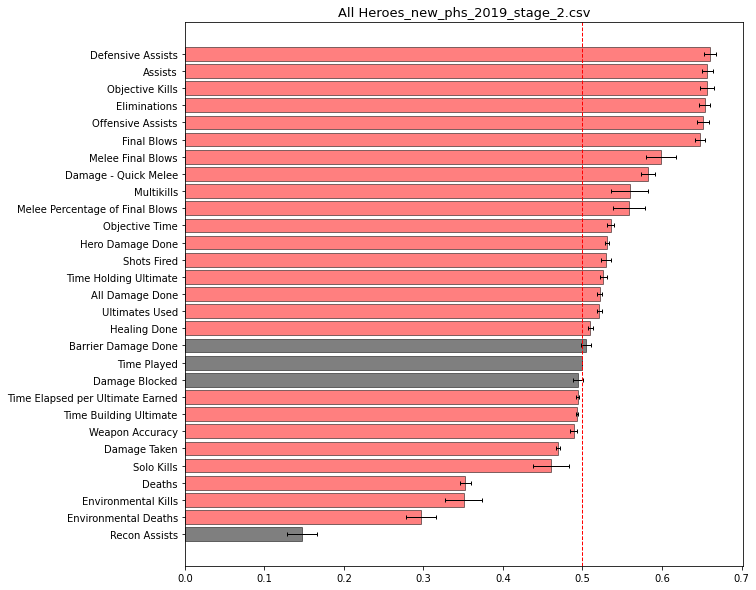

In [5]:
if target_hero == 'All Heroes':
    # t-test
    t, p = ttest_ind(df_norm_0.drop('is_map_winner', axis=1), df_norm_1.drop('is_map_winner', axis=1), equal_var=True, axis=0)

    df_norm_winner_stat = df_norm_1.drop('is_map_winner', axis=1)
    df_norm_winner_stat = df_norm_winner_stat.agg(['mean', 'count', 'std', 'sem']).transpose()
    df_norm_winner_stat['pval'] = p

    # plot winner's stats
    df_norm_winner_stat = df_norm_winner_stat.sort_values(by=['mean'], axis=0)

    color = []
    for p in df_norm_winner_stat['pval']:
        if p<0.05:
            color.append('red')
        else:
            color.append('black')

    df_norm_winner_stat['color'] = color

    if all_seasons == True:
        title = f'{target_hero}_all seasons'
    else:
        title = f'{target_hero}_{phs_name}'

    plt.figure(figsize=(10,10))
    plt.title(title, fontsize=13)
    plt.barh(df_norm_winner_stat.index.values, df_norm_winner_stat['mean'], color=color, alpha=0.5, edgecolor='black', linewidth=1, xerr=df_norm_winner_stat['sem'], error_kw={'ecolor':'black', 'elinewidth':1, 'capsize':2})
    plt.axvline(0.5, 0, 1, color='red', linestyle='--', linewidth='1') # add vertical line on 0.5 (which means winner = loser)

    # save
    if save_mode == True:
        save_path = f'./result/{target_hero}/'
        os.makedirs(save_path, exist_ok=True)
        df_norm_winner_stat.to_csv(f'{save_path}{title}.csv')
        plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

## Compare individual stat

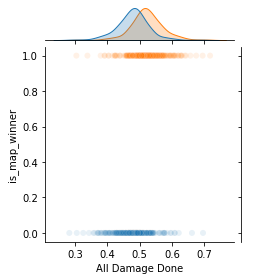

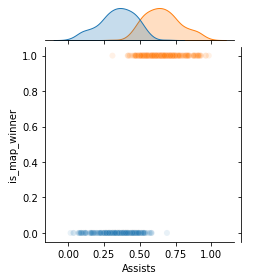

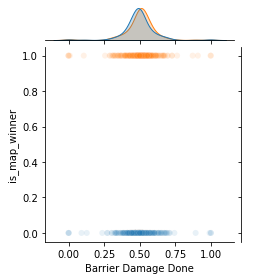

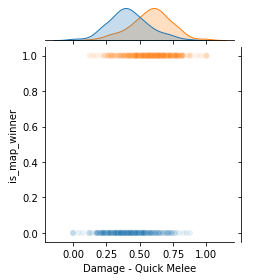

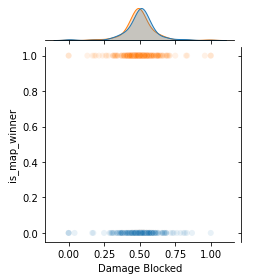

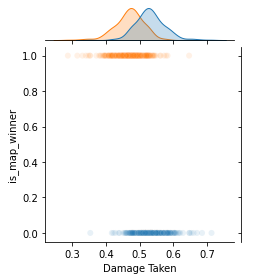

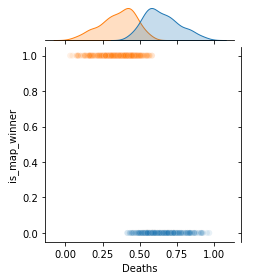

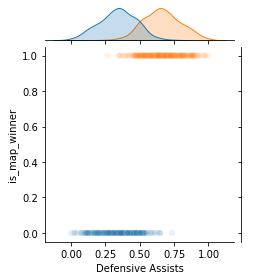

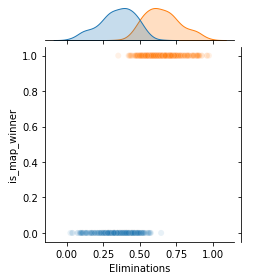

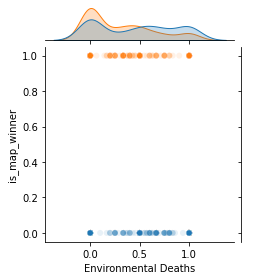

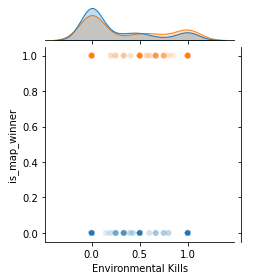

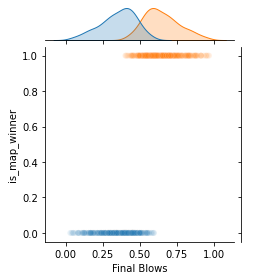

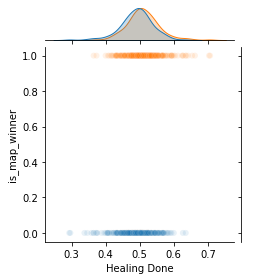

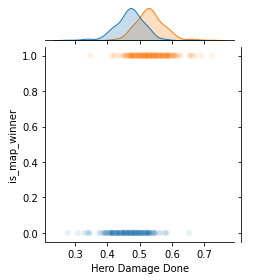

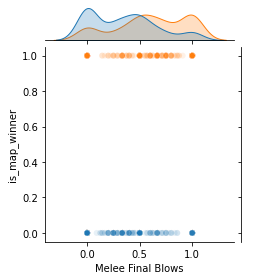

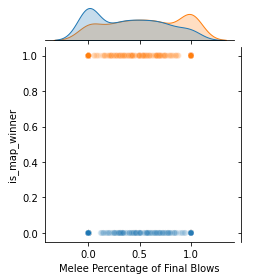

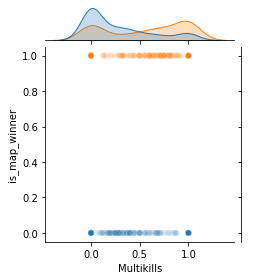

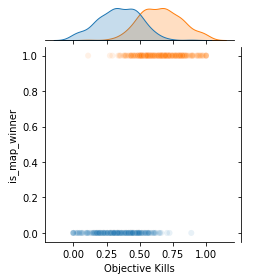

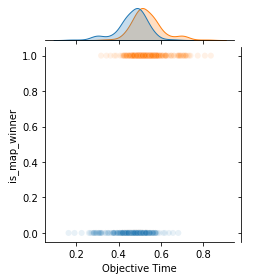

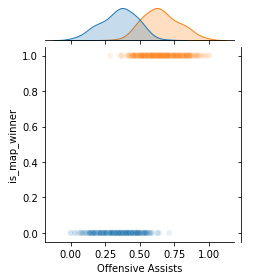

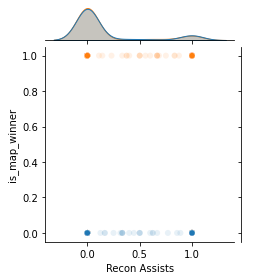

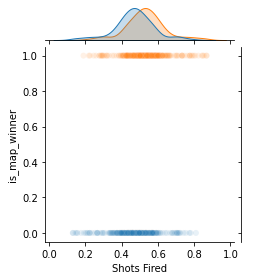

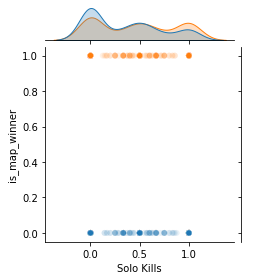

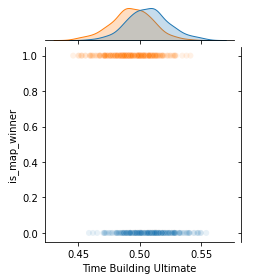

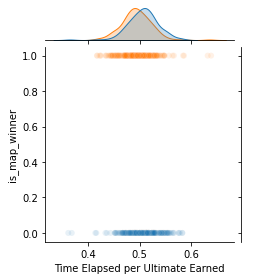

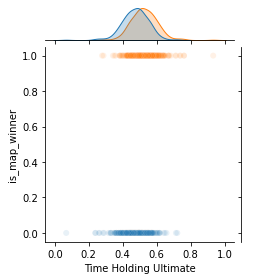

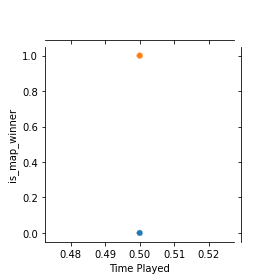

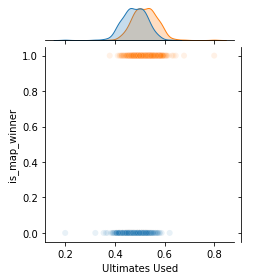

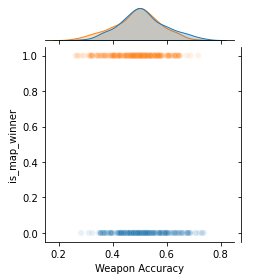

In [6]:
for f in X.columns:
    sns.jointplot(x=X[f], y=y, hue=y, height=4, legend=False, alpha=0.1)

# Data Modeling

In [7]:
# Import pakages for machine learning

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb

from keras.models import Sequential
from keras.layers import Dense

## 1. Logistic Regression

(504, 29) (126, 29) (504,) (126,)
Accuracy: 0.96


cols  abs_coef
26           Time Played  0.000000
17       Objective Kills  0.046056
4         Damage Blocked  0.068756
28       Weapon Accuracy  0.069630
9   Environmental Deaths  0.078074

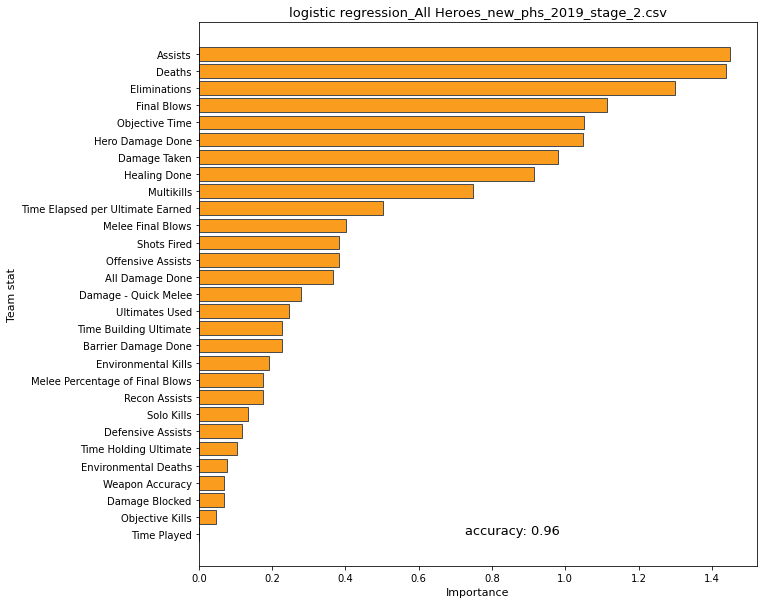

In [8]:
# Set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create the logistic regression model
log = LogisticRegression()
log_fit = log.fit(X_train, y_train)

# Accuracy
accuracy = log.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# Get feature coefficient
coef = log.coef_[0]
# abs_coef = coef
abs_coef = abs(coef)

# summarize feature coefficient
fea_rank_ = pd.DataFrame({'cols': feature_names, 'abs_coef': abs_coef})
fea_rank_.sort_values(by=['abs_coef'], ascending = True, inplace=True)

display(fea_rank_.head())

# Plot feature coefficient
if all_seasons == True:
    title = f'logistic regression_{target_hero}_all seasons'
else:
    title = f'logistic regression_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['abs_coef'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Importance', fontsize=11)

plt.text(x=max(fea_rank_['abs_coef'])/2, y=min(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
if save_mode == True:
    save_path = f'./result/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    fea_rank_.to_csv(f'{save_path}{title}.csv')
    plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

## Explain the model with SHAP

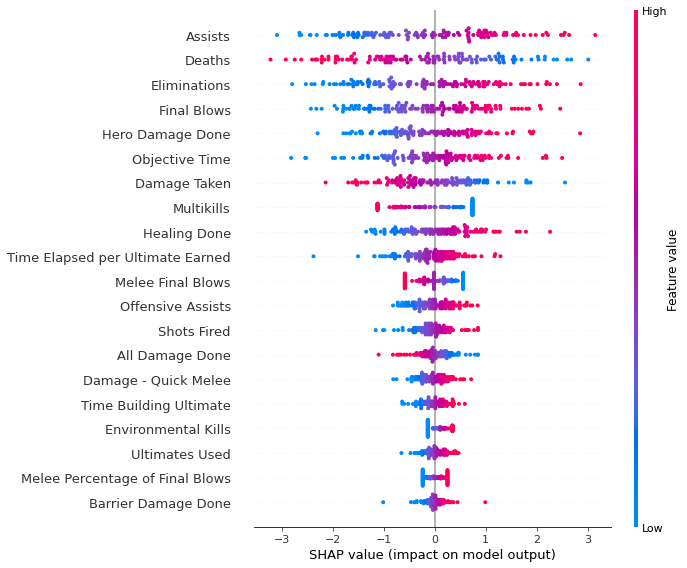

In [9]:
import shap

shap.initjs()

explainer = shap.LinearExplainer(log, X_train) # feature_perturbation='correlation_dependent'
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

Accuracy: 0.96
[False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False]


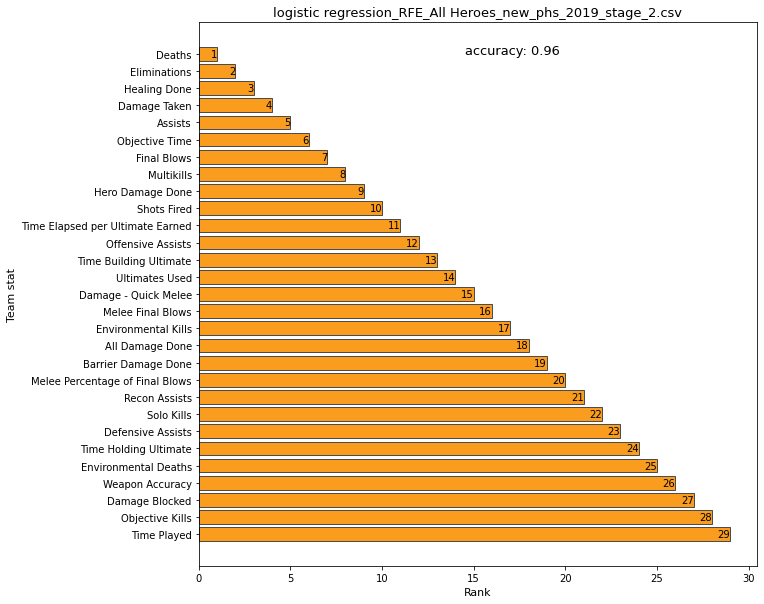

In [10]:
#Recursive Feature Elimination(RFE)

# create the RFE model
rfe = RFE(estimator=log, n_features_to_select=1)
rfe = rfe.fit(X_train, y_train)

# Accuracy
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# summarize the selection of the attributes
print(rfe.support_)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols': feature_names, 'fea_rank': rfe.ranking_})
fea_rank_ = fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending=False)

# Plot feature importance
if all_seasons == True:
    title = f'logistic regression_RFE_{target_hero}_all seasons'
else:
    title = f'logistic regression_RFE_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['fea_rank'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Rank', fontsize=11)

for i in fea_rank_.index: # add values on bar graph
   plt.text(fea_rank_.loc[i, 'fea_rank'], fea_rank_.loc[i, 'cols'], fea_rank_.loc[i, 'fea_rank'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_rank_['fea_rank'])/2, y=max(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
if save_mode == True:
    save_path = f'./result/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    fea_rank_.to_csv(f'{save_path}{title}.csv')
    plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

## 2. LightGBM classification

(403, 29) (126, 29) (403,) (126,)
[LightGBM] [Warning] num_iterations is set=5000, num_boost_round=5000 will be ignored. Current value: num_iterations=5000
Accuracy: 0.95


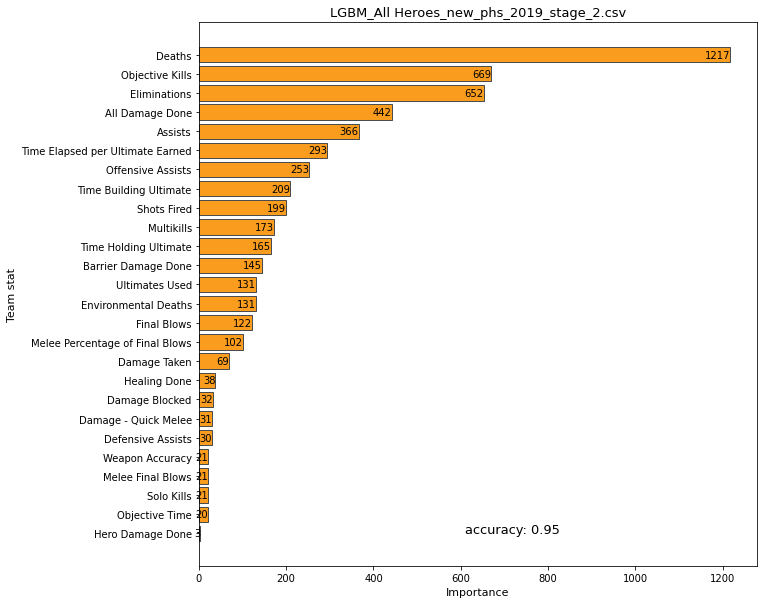

In [11]:
# LightGBM 
'''
note: https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
'''
# set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2) # validation set

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create the lightGBM model
lgbm = lgb.LGBMClassifier(
   objective='binary', 
   boosting_type='gbdt', # gbdt(gradient boosting decision tree), rf(random forest), dart(dropouts meet multiple additive regression trees), goss(Gradient-based One-Side Sampling)
   learning_rate=0.001,
   n_estimators=500,
   num_boost_round=5000,
   )

lgbm.fit(
   X_train, y_train,
   eval_metric='binary_logloss',
   eval_set=(X_val, y_val),
   early_stopping_rounds=1000,
   verbose=False
   )

lgbm.booster_.feature_importance()

# Accuracy
accuracy = lgbm.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols': feature_names, 'fea_imp': lgbm.feature_importances_})
fea_imp_ = fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending=True)

# Plot feature importance
if all_seasons == True:
    title = f'LGBM_{target_hero}_all seasons'
else:
    title = f'LGBM_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_imp_['cols'], fea_imp_['fea_imp'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Importance', fontsize=11)
for i in fea_imp_.index: # add values on bar graph
   plt.text(fea_imp_.loc[i, 'fea_imp'], fea_imp_.loc[i, 'cols'], fea_imp_.loc[i, 'fea_imp'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_imp_['fea_imp'])/2, y=min(fea_imp_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
if save_mode == True:
   save_path = f'./result/{target_hero}/'
   os.makedirs(save_path, exist_ok=True)
   fea_imp_.to_csv(f'{save_path}{title}.csv')
   plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

[LightGBM] [Warning] num_iterations is set=5000, num_boost_round=5000 will be ignored. Current value: num_iterations=5000
Accuracy: 0.92
[False  True False  True  True False  True False  True False False  True
 False False False False False  True False False False False False  True
  True False False False  True]


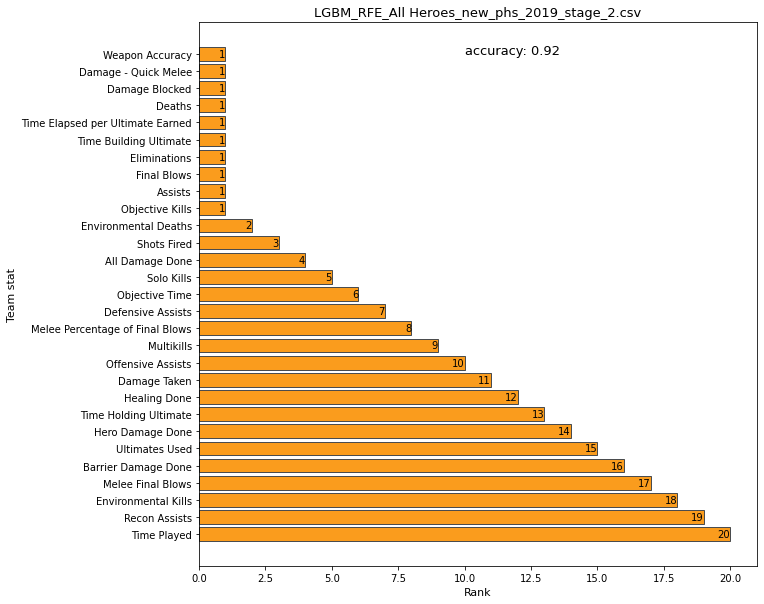

In [12]:
#Recursive Feature Elimination(RFE)

# create the RFE model
rfe = RFE(estimator=lgbm, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Accuracy
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# summarize the selection of the attributes
print(rfe.support_)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols': feature_names, 'fea_rank': rfe.ranking_})
fea_rank_ = fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending = False)

# Plot feature importance
if all_seasons == True:
    title = f'LGBM_RFE_{target_hero}_all seasons'
else:
    title = f'LGBM_RFE_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['fea_rank'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Rank', fontsize=11)
for i in fea_rank_.index: # add values on bar graph
   plt.text(fea_rank_.loc[i, 'fea_rank'], fea_rank_.loc[i, 'cols'], fea_rank_.loc[i, 'fea_rank'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_rank_['fea_rank'])/2, y=max(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
if save_mode == True:
    save_path = f'./result/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    fea_rank_.to_csv(f'{save_path}{title}.csv')
    plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

## 3. Deep neural network

(504, 29) (126, 29) (504,) (126,)
29


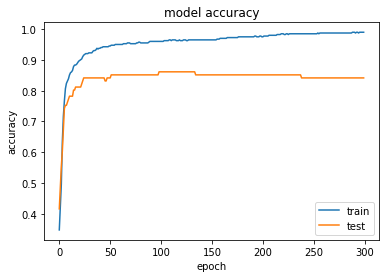

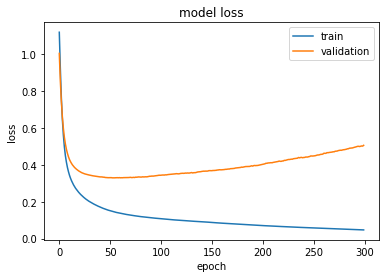

4/4 [==============================] - 0s 1ms/step - loss: 0.3196 - accuracy: 0.8968


[0.319642037153244, 0.89682537317276]

In [13]:
# Set train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
num_input_node = len(X_train.columns)
print(num_input_node)

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Setup a model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(num_input_node,)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=300, verbose=0)

# Plot model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Evaluate the model
eval = model.evaluate(x=X_test, y=y_test)
eval
